# CSE 541 Final 2022

Evan Komp

I declare that I did not recieve anyone's help over the multiple hours being a dungeon gremlin working on this.

***
***
## Problem 1: Non-stationary bandits
### 1.1

This one is a toughy. For arms $i\in[k]$, the mean reward is shifting with time: $\mu_{i,t} = \mu_{i,0}+\alpha_t$ where $\alpha_t$ is a function dependant only on time, not on arm. Reward $X_{i,t}$ is bounded in $(0,1)$ and so of course the mean is within that range as well.

Define $\Delta_i = \mu_{1,0} - \mu_{i,0}$ where arm $1$ is the arm with highest mean reward.

I notice immediately that $\mathbb{E}[X_{1,t} - X_{i,t}] = \Delta_i$ is not time dependant. In this way we can think to construct a high probability estimation of $\Delta_i$ as $\hat{\Delta}_i$ and treat the problem similar to a MAB.

Like the hint suggests, let's consider some action taken $I_t$, action probability $P_t$ taken from distribution $u(i|t)$, observation $X_t$ data taken over $\tau$ timesteps:

$$\hat{\mu_{i,t}} = X_t\frac{\mathbb{1}\{I_t=i\}}{P_t}$$

$$\hat{U}_i = \tau^{-1}\sum_{t=1}^\tau\hat{\mu_{i,t}}$$

And where things diverge from in class:

$$\hat{\Delta}_i = \textrm{max}_j \hat{U}_j - \hat{U}_i$$

We can conduct a very similar analysis to that led us to Bernsteins in class for policy evaluation. We can consider this problem like a contextual bandit except in this case there is only $k$ total policies: always pull one of the $k$ arms.

Let's look at some statistics:

$$\mathbb{E}[\hat{\mu_{i,t}}|t] = \mathbb{E}\left[X_t\frac{\mathbb{1}\{I_t=i\}}{P_t}|t\right]= \sum_{i'\in[k]}u(i)\mathbb{E}\left[X_t\frac{\mathbb{1}\{I_t=i\}}{u(I_t|t)}|t, I_t=i'\right]$$

Now we will be sampling randomly during $\tau$, so $u = k^{-1}$ always:

$$=\sum_{i'\in[k]}k^{-1}\mu_{i',t}\frac{\mathbb{1}\{i'=i\}}{k^{-1}} = \mu_{i,t} = \mu_{i,0} + \alpha_t$$

It is unbiased on its intended estimation. Also:

$$\mathbb{E}[\hat{U}_i] = \tau^{-1}\sum_{t=1}^\tau\mathbb{E}[\hat{\mu_{i,t}}|t] = \tau^{-1}\sum_{t=1}^\tau \alpha_t + \mu_{i,0} = A_\tau + \mu_{i,0}$$

And finally:

$$\mathbb{E}[\hat{\Delta}_i] = \textrm{max}_j \mathbb{E}[\hat{U}_j] - \mathbb{E}[\hat{U}_i] = \textrm{max}_j (A_\tau + \mu_{j,0}) - (A_\tau + \mu_{i,0}) = \textrm{max}_j \mu_{j,0} - \mu_{i,0} = \Delta_i$$

Great. Now let's analyze the variance. This is where I go downhill and get a poorer regret bound than asked for. 

$$\mathbb{E}[(\hat{\Delta}_i - \Delta_i)^2] = \mathbb{E}\left[(\textrm{max}_j\tau^{-1}\sum_{t=1}^\tau(\hat{\mu_{j,t}}-\hat{\mu_{i,t}}) - \Delta_i)^2\right]$$

$$\le \mathbb{E}_t\left[\mathbb{E}\left[(\sum_{j\ne i}\tau^{-1}\sum_{t=1}^\tau|\hat{\mu_{j,t}}-\hat{\mu_{i,t}}| - \Delta_i)^2|t\right]\right]$$

$$\le \mathbb{E}_t\left[\mathbb{E}\left[(k-1)-\Delta_i)^2|t\right]\right] \le k^2$$

That sucks. I have $k^2$ instead of $k$ so my bound will be off, but not sure how else to stage the problem or analyze the variance.

With this nonbiased estimator with variance $k^2$ we can use bernsteins exactly as we did in class, I'll refer you there to both save typing and pretend like I have it memorized:

$$\mathbb{P}\left(\bigcup_{i\in[k]}\left\{|\Delta_i-\hat{\Delta}_i|\le \sqrt{\frac{2k^2\ln{(2k/\delta)}}{\tau}} + \frac{2\ln{(2k/\delta)}}{3\tau}\right\}\right) \le \delta$$

Here I made use of the fact that the rewards are bounded in $(0,1)$. Also notice that our policy space is the same size as our action space $k$ as mentioned before. Thus:

$$|\Delta_i-\hat{\Delta}_i|\le\sqrt{\frac{4k^2\ln{(2k/\delta)}}{\tau}}$$

with probability $\ge 1-\delta$

Cool. Now let's define an algorithm that looks a lot like the MAB eliminator, with a few tweeks.

$l\leftarrow 1, \Pi_l \leftarrow [k]$

while $|\Pi_l|> 1$
- $\epsilon_l = 2^{-l}$
- pull each arm $I_t\in\Pi_l$ selected randomly a total of $\tau_l$ times. $\tau_l$ will be determined later
- construct the IPS $\hat{\Delta}_{i,l}$ for each arm according to the data taken this $l$, see definition above
- $\Pi_{l}\leftarrow \Pi_{l}$ remove $\left\{i\in\Pi_l: \hat{\Delta}_{i,l}-\textrm{min}_{j\in \Pi_l}\hat{\Delta}_{j,l}\ge 3\epsilon_l\right\}$
- $l \leftarrow l+1$

Define the event $\mathcal{E}_{i,l} = \left\{|\Delta_i-\hat{\Delta}_{i,l}|\le\sqrt{\frac{4k^2\ln{(2k/\delta)}}{\tau_l}}\right\}$ which we know to be true wp $1-\delta$ as shown above.

We want:
$$\epsilon_l = \sqrt{\frac{4k^2\ln{(2k/\delta)}}{\tau_l}}$$

So choose $\tau_l = 4\epsilon_l^{-2}k^2\ln{(2k/\delta)}$ rounded up.

Let's say $\Delta_i\le C\epsilon_l$ for some constant $C$. In this case, on our events:

$$\hat{\Delta}_{i,l} \le \Delta_i + \epsilon_l = (C+1)\epsilon_l$$

$$\textrm{min}_{j\in \Pi_l}\hat{\Delta}_{j,l} \ge \Delta_1-\epsilon_l = -\epsilon_l$$

So...

$$\hat{\Delta}_{i,l}-\textrm{min}_{j\in \Pi_l}\hat{\Delta}_{j,l} \le (C+2)\epsilon_l$$

Thus if $\Delta_i\le \epsilon_l$, we have $\hat{\Delta}_{i,l}-\textrm{min}_{j\in \Pi_l}\hat{\Delta}_{j,l} \le 4\epsilon_l$ and it will not be removed on round $l$. Congruently, for $\Delta_1 = 0$, it will never be removed (high probability) since $\epsilon_l>0$ for all $l$.

Similarly, for $\Delta_i = C'$, arm $i$ is gauranteed (high prob) to be removed at round $l=\log_2{C'^{-1}}$.


With these proved, determining a regret bound is a matter of determining the expected bound on number of pulls of arm $i$, $T_i$. This stops increasing when arm $i$ is removed which we showed was after $\Delta_i\ge \epsilon_l$. I breeze over these steps a bit since they are identical to the MAB eliminator shown in class except with a different $\tau_l$. So when then have:

$$T_i = \sum_l^{\lceil \log_2{(\Delta^{-1})}\rceil}\tau_l\mathbb{1}\{i\in\Pi_l\}\le \sum_l^{\lceil \log_2{(\Delta^{-1})}\rceil}\tau_l$$


Note that $\Delta = \mathrm{min}_{i\ne1}\Delta_i$

Pluggin in $\tau_l$ and stopping once arm $i$ is removed:

$$T_i\le C\Delta_i^{-2}\ln{(4\log_2^2{(2\Delta_i^{-2})}k^2\delta^{-1})}$$

The regret is just the sum of these for all but the optimal arm times the instantaneous regret of that sub optimal choice:

$$R_T = \mathbb{E}\left[\sum_{i\in[k]}T_i\Delta_i\right] \le \mathcal{O}\left(\sum_{i\ne1}\Delta_i^{-1}\ln{(k^2T\log_2{(\Delta_i^{-1}])})}\right)$$

Unfortunately I did not achieve the desire by a factor of $\sqrt{k}$. Not sure how I can better bound the variance of the IPS estimator on $\Delta$. Note that to get our worst case instance independant regret, we have to decompose our high probability regret, eg:

$$\mathbb{E}\left[\sum_{i\in[k]}T_i\Delta_i\right] = \mathbb{E}\left[\sum_{i:\Delta_i<\nu}T_i\Delta_i\right] + \mathbb{E}\left[\sum_{i:\Delta_i\ge\nu}T_i\Delta_i\right]$$

For some $\nu > 0$. Then use our high probability bound and the fact that $T_i\le T$, minimizing with respect to $\nu$, and making a good choice of $\delta$.

### 1.2 

Yay! Each day is just its own bandit with stationary means. Run a MAB on each day, say UCB, and achieve $7\sqrt{kT}$ where $T$ is the number of weeks, where the minimax optimal regret for UCB MAB was taken directly from the book. If there are holidays this complicates things a bit... you could chose to just not treat them differently and incur linear regret of at most $NT/W$ where $W$ is the number of weeks in a year. You could also chose to run UCB on each holiday individually and definately do better, removing that linear component down to $N\sqrt{kT/W}$ which is clearly better.

***
***
## Problem 2: Scenarios in real world


__Note__: 
1. I don't always specify a specific baseline to compare to, and when I don't assume that one might try random choice as a baseline. If we cannot get much better than that, it may not be the right algorithm.
2. Sometimes I discuss a feature map $\phi$. If not specified otherwise, this is an encoding of incoming context to an action's indices like discussed in class and in HW 3.
***

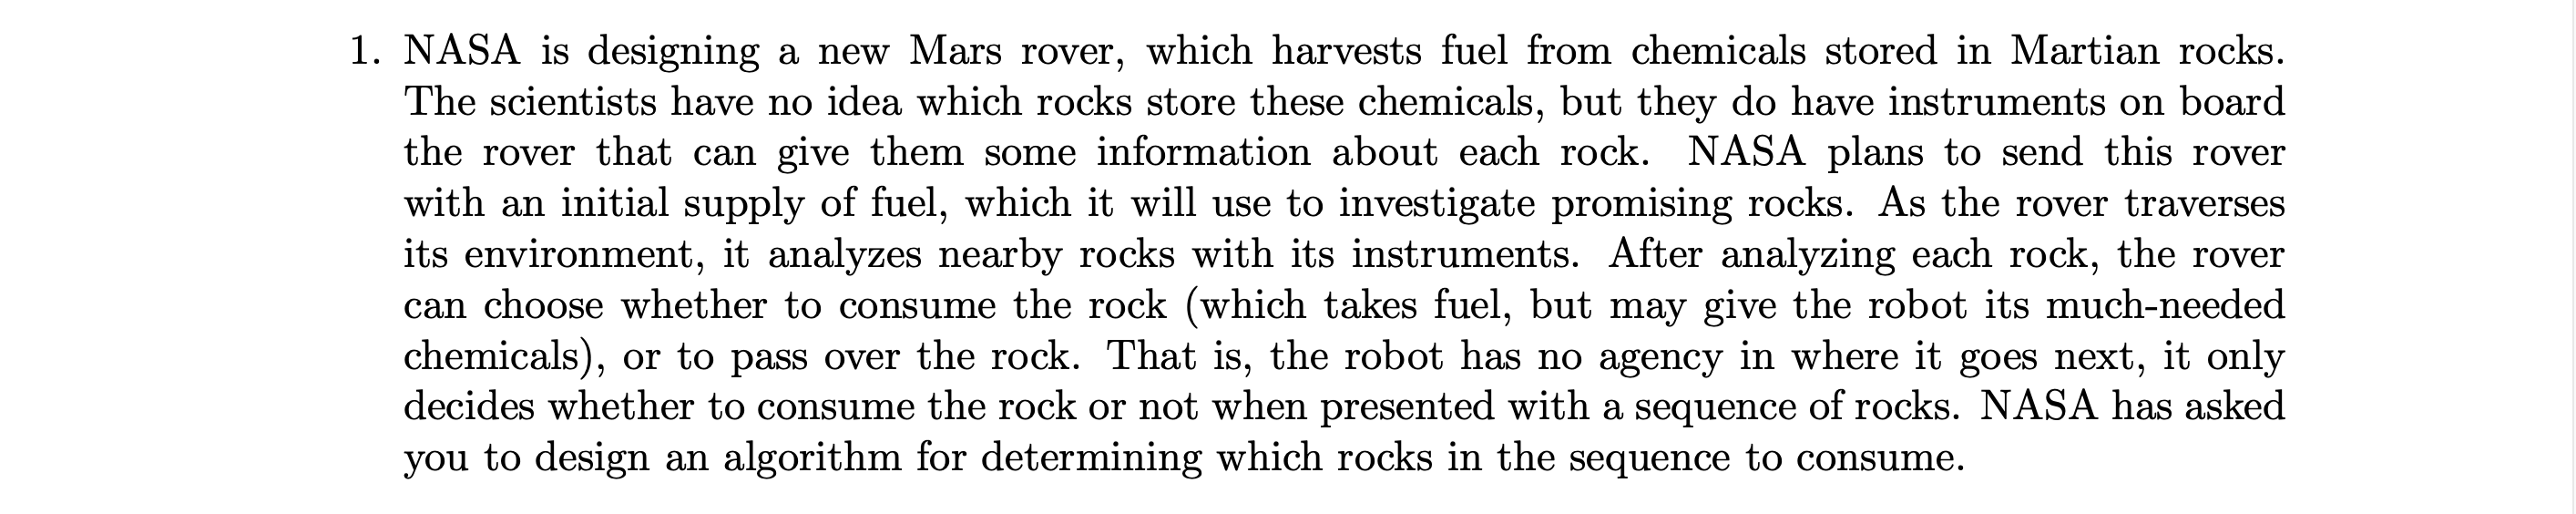

This is a regret minimization problem. While exploration is scientifically desirable, the primary goal is to ensure the rover does not run out of fuel, and suboptimal choices may cause this. This is probably best formulated as a contextual bandit problem. This is because we can acquire information about a rock that we anticipate is associated with fuel content, before actually committing collecting the rock's fuel, but we must make the choice to collect or not at the time that we see the rock, as opposed to having knowledge of all rocks in the area before making the decision. Additionally, while many rocks will be similar, none will be exactly the same, so we have an infinite context space.

Some assumptions:

1. A linear model acting on the collectable features is adequate to make a good determination of fuel content. That is, that an optimum linear model can successfully identify rocks that on average produce more fuel than is used in collection and in travel to the rock, a net gain.
2. The cost of taking measurements on a rock in fuel (either to run the instruments or the fuel cost in time it takes to run the measurement) is negligible. 
3. Rocks (more specifically the feature vectors associated with the rocks) come in randomly at the same probability as their overall distribution on the planet. This is probably fine, as the rover is roving and not in one location depleting resources.
4. Ideally the fuel cost between discovering a rock is neglible. If there is a "dry period" we are just kind of screwed. To not make this assumption we would have to start considering the rover's path as part of the decision making process, which significantly complicates the problem.

- __Context__: $c_t\in\mathcal{C}$ - The measurements we can take from a rock upon its appearance
- __Action__: $a_t\in\mathcal{A}$ - Binary collect or do not collect the rock
- __Policy__: $\pi(c_t)\in \Pi: \mathcal{C}\rightarrow\mathcal{A}$
- __Reward__: $r_t = \theta_*^T\phi(c_t, a_t)$ - Net fuel gain


Lin-UCB will be optimal for this situation. A greedy algorithm could be detrimental - as we only have a set amount of initial fuel, if we do not collect enough fuel when randomly selecting rocks, we are SOL. LinUCB achieves optimal worst case regret of $\mathcal{O}(\sqrt{(|\Pi|N\ln{(N)})})$ after $N$ rocks. If the number of measurements we are taking is $M$, use an encoding mapping for $\phi$ eg a $2M$. Note that for LinUCB then $|\Pi|=4M$ since we have binary action space. This is fairly amenable assuming the number of measurements is not enourmous. 

As a initial test, one could use some of the initial fuel to collect rocks that all have approximately the same feature vector and cllect their fuel. If the fuel content of these is wildly varied, it may not be possible for the linear model to approximate the mean reward without taking extreme amounts of samples, in which case it make be better to consider a different strategy. One final note to make is that if the context vector can be used to accurately categorize rocks into $L$ categories, and each of those categories produces a tight reward distribution, it may be better to run a UCB MAB algorithm on each of L categories, achieving a regret $\mathcal{O}(L\sqrt{2(N\ln{(N)})})$. If this is true and $L\sqrt{2} << \sqrt{2M}$, that may be a better strategy. We can also spend some initial fuel either randomly deciding to collect rocks or collecting all rocks as a baseline.

***
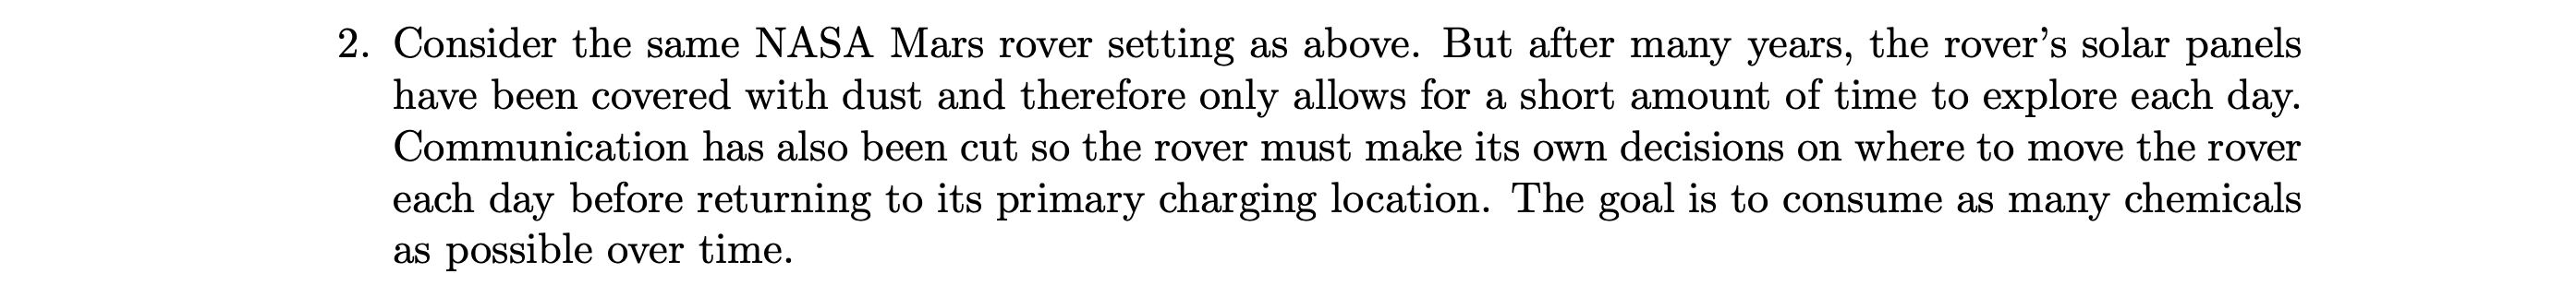

Given that we now are not as concerned with regret minimization or exploration, but maximum collection, we are in a more greedy mindset. Unfortunately the rover is now constrained to a location as opposed to alowed to roam. This complicates our assumption of rocks being indepentant each day, as one productive location can be exausted and is no longer a high reward area. Finally, since the rover must make its own movement decision, the overally problem is immensely more complex. Given that we have years worth of data on single-rock reward, and the rover has lasted this long, that policy is probably good enough to just use. Now we have to focus on learning a movement policy, and we reset at the end of each day. This reads more like an MDP, however given that rocks will be depleted over time I do not see how it is possible to "reset the board state", and secondarily, the productivity of a specific section of land is not fixed. For this reason we have to very carefully define our actions and states. We will be considering the nearby land within reach in sectors.

Some new assumptions:
1. The single rock policy that we developed over years is near optimum, and we can use it greadily.
2. There is a fixed amount of space possiblly accessible to the rover, outside of which there is simply not enough fuel to get to.
3. Each sector is the same size, and is sufficiently large that the rover cannot traverse it entirely in one "time step"
4. The amount of fuel collected from a sector in one timestep is sufficiently large that it is approximately the instantaneous productivity of the sector.

- __State__: $s_t\in\mathcal{S}$ - The current amount of fuel, the distance from the charging station, and the last known productivity of each sector ("board state")
- __Action__: $a_t\in\mathcal{A}$ - Which sector to move to, or stay in the same sector, or go home.
- __Policy__: $\pi(s_t)\in \Pi: \mathcal{C}\rightarrow\mathcal{A}$
- __Reward__: $r_t$ - Net fuel gain over the full day

Hardcode a few things into the action policy:
1. If the net productivity of a sector was negative, remove it from the game entirely, until all sectors report net loss then introduce them all back in. At this point we are dying and struggling to last as long as possible.
2. If the sun is about to rise, go home.

Given that the reward is now end-of-day fuel gain, the impact of fuel loss by traveling between sectors is taken into account by the algorithm. Initialize each sector with infinite expected productivity. During each time step, use the greedy policy developed over years to determine of a single rock is worth collecting. Use UCB VI and roll out each day. The important difference between this and MDPs considered in class is again that the board state is not reset each day, so we cannot assume a sector will be as productive as it was before, meaning its state is not specified by its location alone but also its last known productivity. Hopefully we achieve UCB VI regret.

***
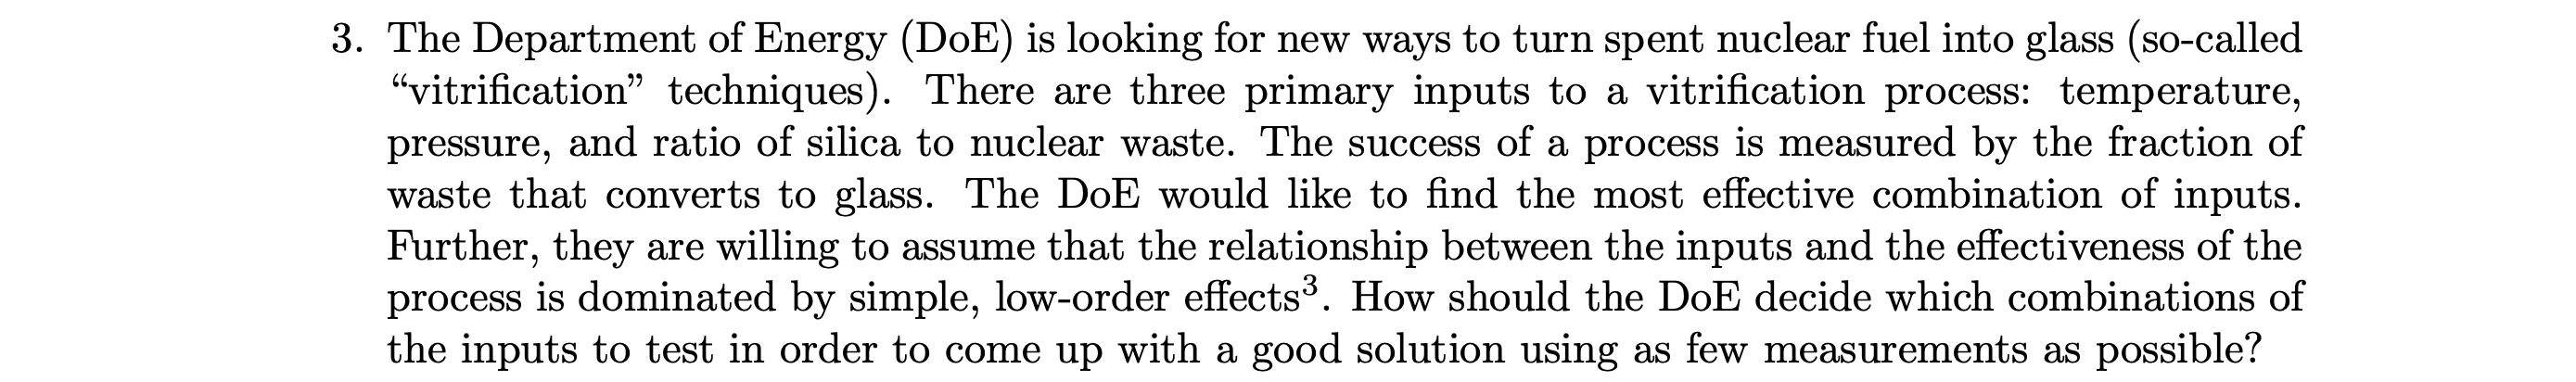

Initially this seems a contextual bandit problem, with incoming context silica content, and possible actions to take as the temperature and pressure. This would make sense to me as it is difficult to just "chose" the silica content without comprimising the effectiveness of the fuel. But it is worded ("...looking for the best combination of inputs") as if the DoE is in control of silica content, in which case we have a "linear" bandit problem, except that the three inputs are not the linear features the model will see. Instead the features are constructed according to the hint, a mapping from temperature, pressure, silica to a 6 length feature vector. This seems a pure exploration problem.

Some assumptions:
1. The DoE can preemtively enforce a silica content in nuclear fuel such that they can test this process and in the future enforce the amount that is optimal.
2. The reward is deterministic or evenly distributed as a function of the inputs.
3. The vitrification process is not changing in the future, or changes to the optimum inputs as a result of changing technology is predictable.
4. The DoE has access to a fixed set of samples up front, that spans the range of silica contents

- __Action__: $x_t\in\mathcal{X}$ - The feature vector for any sample in the set 
- __Reward__: $r_t = \theta_*^Tx_t$ - Percent vitrification

I am tempted to suggest simply executing a $\tau$-greedy algorithm, where for some number of total tests, we run a G-optimal design on the sample set, produce a predictor, and then suggest a specific feature vector forever after, but unfortunately I do not think one can gaurantee the the "optimal" feature vector is mappable back to the three inputs, given the interaction terms. Next one could always just choose samples randomly or according to G and just select the best from that set. However if the DoE is not running a fixed time experiment, eg. they do not have a maximum number of samples that they can run, they might consider running the linear elimination algorithm. This only runs samples in round 1 $\tau_l\propto\sqrt{|\mathcal{X}|}$ times. This strategy is not actually any different than the $\tau$-greedy __if__ $\tau=\tau_0$ and the reward is deterministic, however if the DOE can run as many samples as they like and the reward measurement is sufficiently varied than the elimination is a better choice.

***
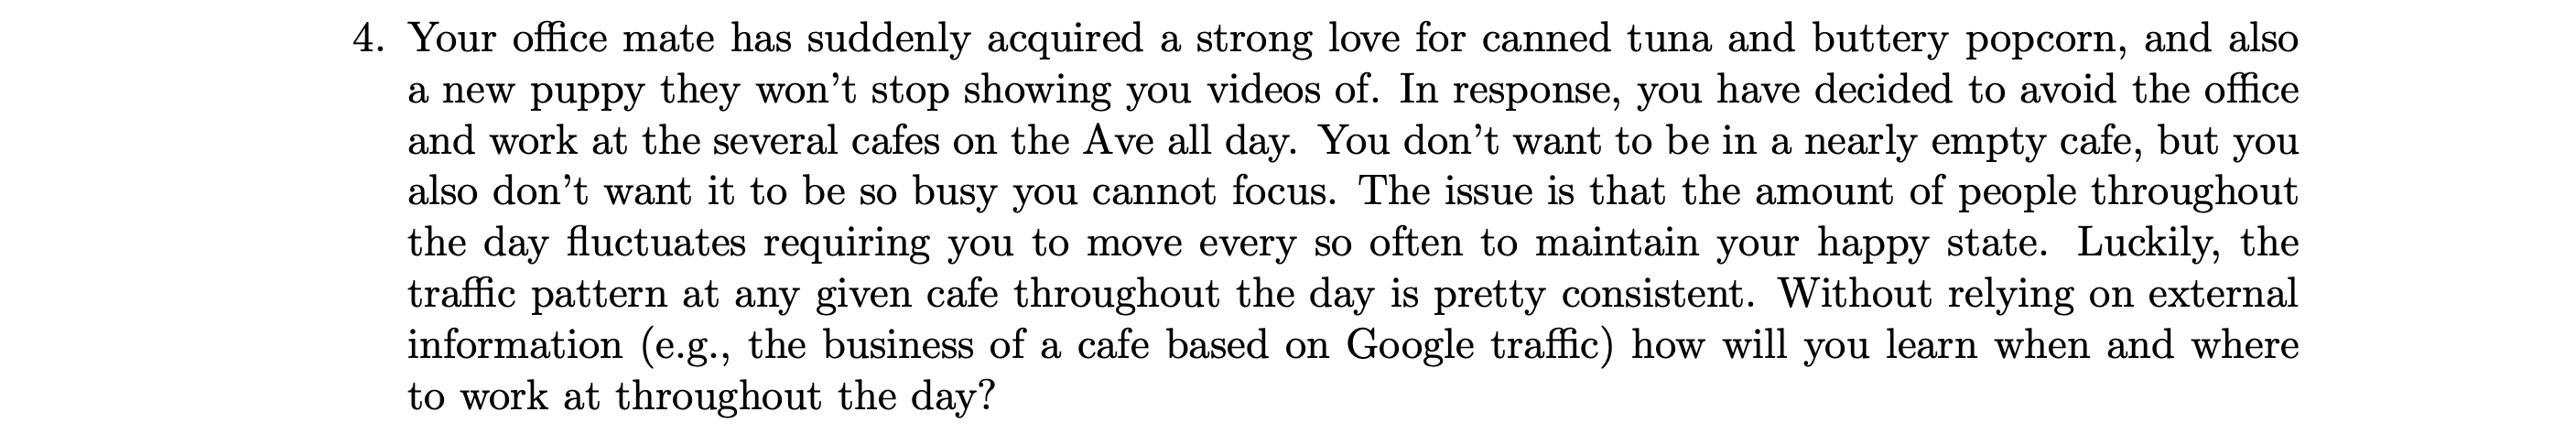

I lol'ed at the setup of this question, thank you. This gives me MDP vibes, but strictly because we have an instantaneous reward __and__ the traffic at each cafe consistent across days, I think that is significantly overcomplicating the problem. Instead we will discretize the day into 8 hour chunks and call it an 8 MAB problems acting on $n$ possible cafes. Regret minimization.

Some assumptions:
1. I am an emotionally aware human and I can instantaneously decide if I am binary happy or even linear scale happy. I could go to the same cafe at the same time on multiple days to test this and see if my happiness is normally distributed, but I think there would be some bias there.
2. The time it takes to move between cafes is non negligible and also increases grumpiness, so trying to move around more than once an hour is counter productive.
3. Day consistent traffic like the problem states.

For each hour in the work day define an MAB with arms $i\in[n]$ cafes.

- __Reward__: $\mathbb{E}[r_i,t] = \mu_i,t$ - Happiness (binary or linear scale) of cafe $i$ during hour $t$

Here timesteps are days $d$. If we just run UCB on each time chunk we get $R_D \le \mathcal{O}(8\sqrt{Dn})$ Where D is the number of days.
It is worth noting that we could consider a linear bandit by mapping $\phi(t,i)\in\mathbb{I}^{8n}$ to get regret more like $R_D \le \mathcal{O}(\sqrt{8nD})$ because we are not longer running 8 MABs but one linear bandit over time and location, but is it so worth it?

***
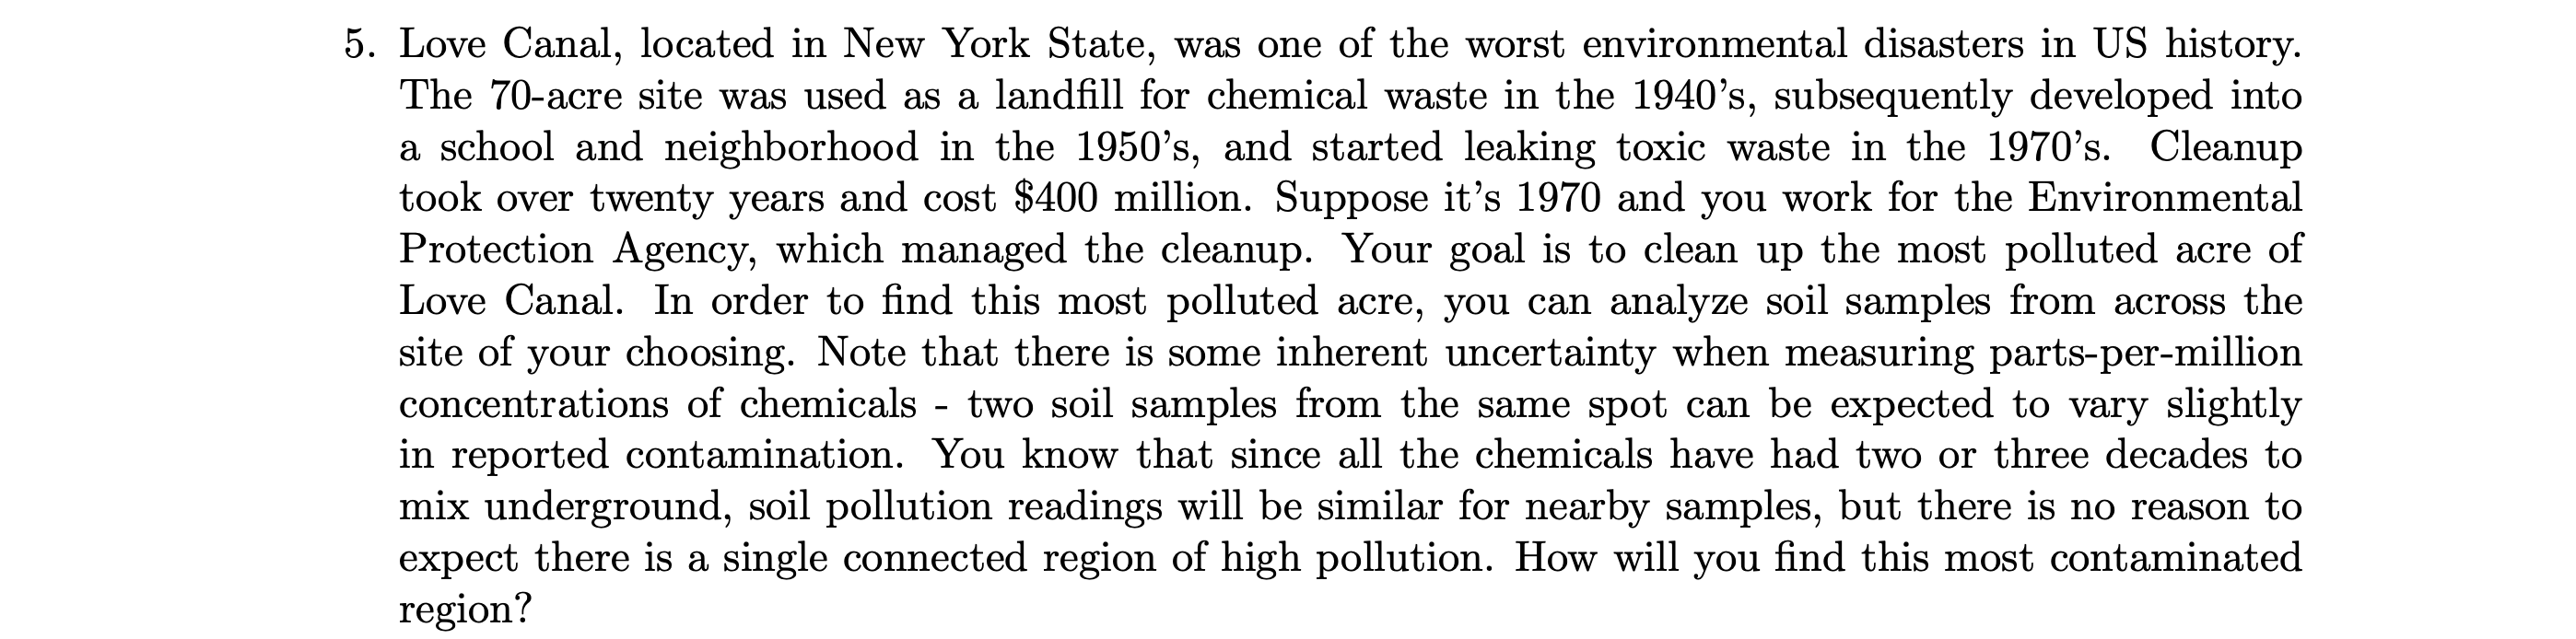

This seems like it would be most aptly approached as a non parametric bandit problem. We essentially have a toxicity surface where the expected toxicity reading is a function of latitude, longitude position. Congruently, by the mechanisms of diffusion in topsoil, it is unlikely to experience discontinuous changes in toxicity with the exception of surface rock. Because of this, a lipshitz assumption is probably a good one. Exploration.

Some assumptions:
1. Our instrumentation measurement has approximately normal noise. Test by taking many samples from one spot.
2. Toxicity as a function of location is lipshitz continous. Take samples in a line along one direction to test.
3. A non parametric mapping to $d$ dimensions can sufficiently capture the nonlinear function.

- __Action__: $\phi(lat,lon)\in \mathbb{R}^d$ a mapping of the position of the sample.
- __Reward__: $r(\phi) = \mu_{lat,lon} + \eta$ The measurement of the sample at a location.

Discretize latitude, longitude, into acre chunks, map to kernel. Run linear-kernel elimination on the sample set sectors. Probably no need to run Frank since we can uniformly sample sector space, unlike in HW2 where the sample set was not uniform. Identical process to that homework except our mapping is from 2 dimensions to $d$ instead of from 1.

***
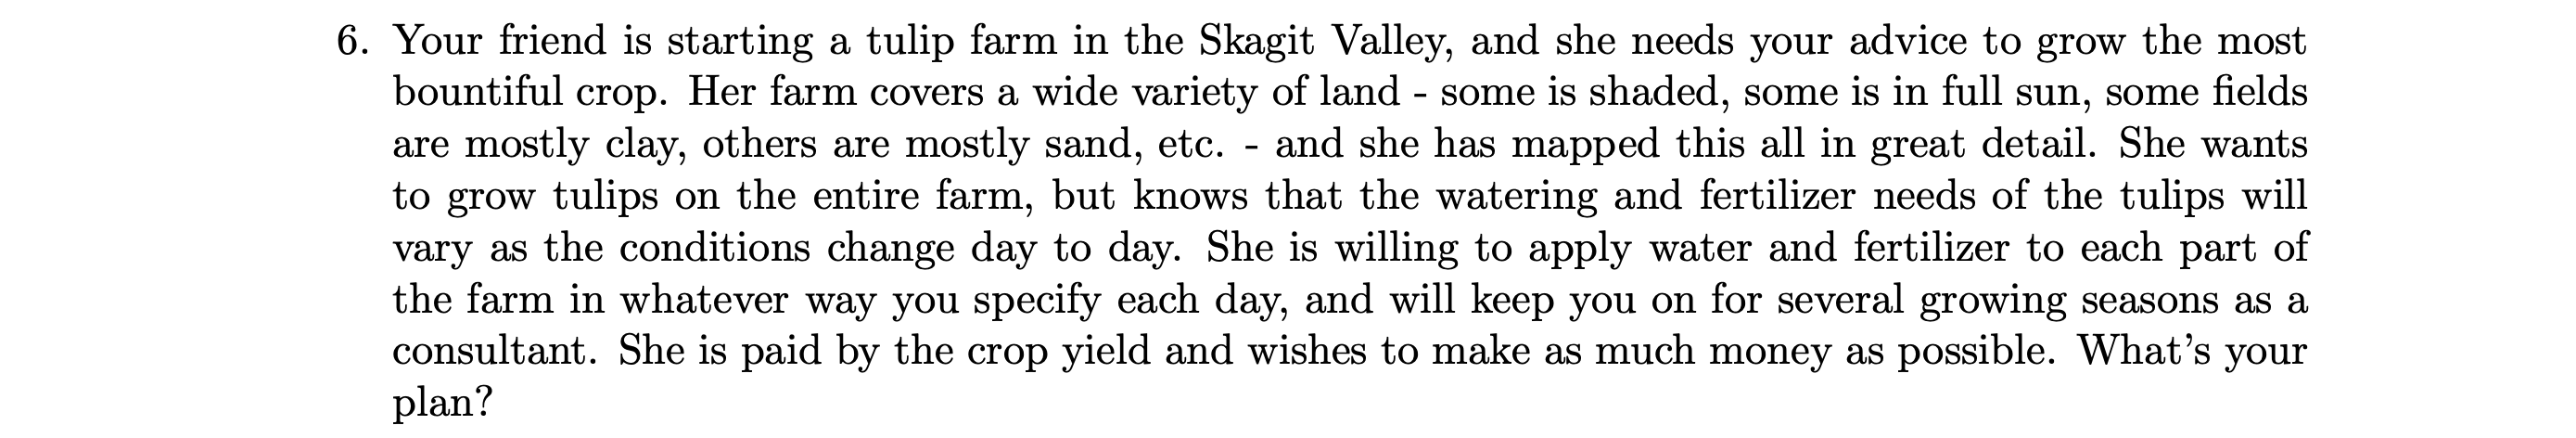

This one is tougher than it seems at a glance. The biggest problem is that I cannot conceive of a way to measure reward short of year-end product. Because of this the timesteps are a full year, so it is really important to limit the sample space as much as possible. Because of this we want to find a minimal feature space that effectively captures the effect of the two independant variables on the reward given the context. I would set this up as a contextual bandit with the land space as context, and the fertilizer and water input as action. Regret minimization.

Some assumptions:
1. Year by year conditions are identical. This isn't true due to climate change etc. but to avoid this assumption we'd have to do forecasting. Maybe an MDP, but that would take years to gather information. Could use the same input in one location for multiple years to test.
2. There is a linear function that adequately correlates the expected year end yield to the land and the inputs.
3. Tulip species all behave the same. Test by planting multiple in the same location with the same input, measure yield.


- __Context__: $c_t\in\mathcal{C}$ - Feature vector for the land
- __Action__: $a_t\in\mathcal{A}$ - Fertilizer and water input.
- __Policy__: $\pi(c_t)\in \Pi: \mathcal{C}\rightarrow\mathcal{A}$
- __Reward__: $r_t = \theta_*^T\phi(c_t, a_t)$ - year end yield

Here $\phi(c_t, a_t)$ is a mapping from the land status and farmer input to expected reward. It is difficult for me to expand on how this feature mapping would occur, because I am unsure of the form of the map data. If the land can be easily classified into a small set of $m$ classes, we could think to map the two inputs to indices associated with the land class and have $\phi\in\mathbb{R}^{2m}$. If otherwise the land has a feature vector itself, then potentially a nonlinear kernel of the concatenated land and input features. Farmer input is clearly coupled to the land, so directly using the concatenated vectors means we have each input as independant which is probably not a good assumption. Run linUCB on the resulting mapping.

***

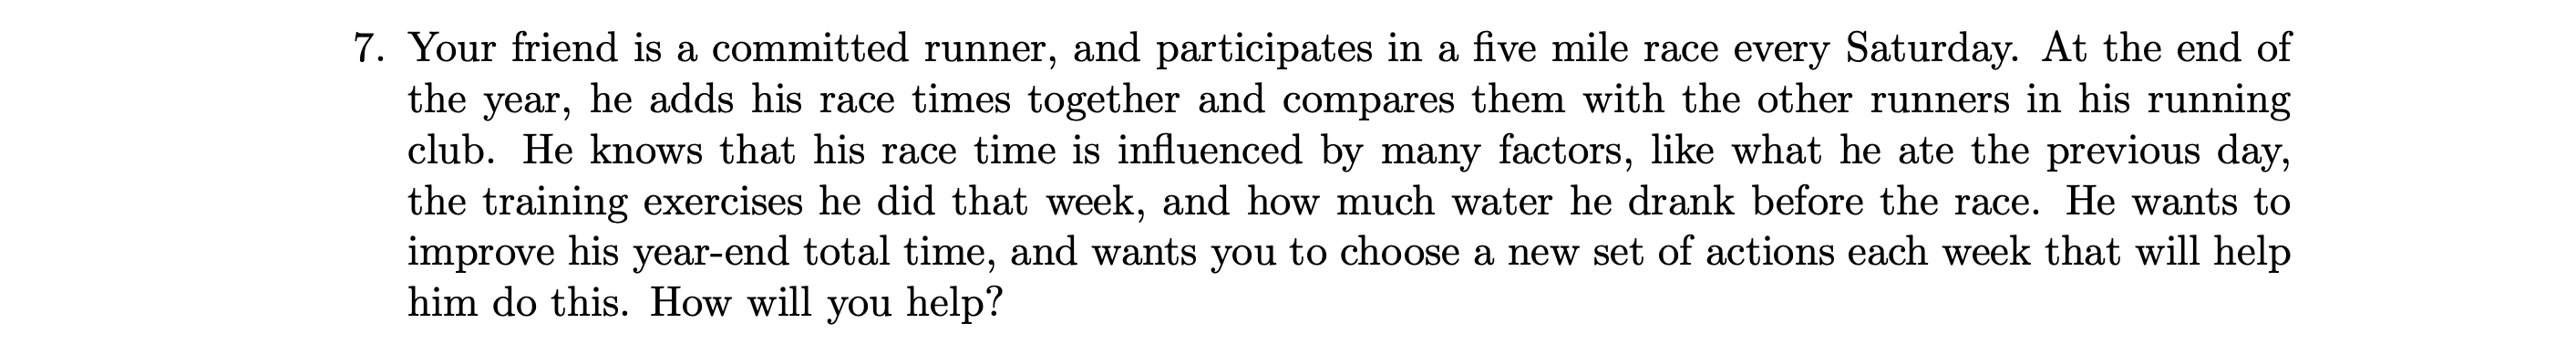

One might consider this a MDP, with past performance and actions effecting weeks far in the future, but being a runner I think that is a bit of a stretch. For the most part, what works one week will work the next, and there is rarely an advantage for wild swings in habits to achieve long-time reward, maybe with the exception of resting before a big race. But since there is not some big race at the end of the year, and instead this is a repetative weeklong process, it would be better to consider this a linear bandit. Define all desirable features, randomly sample uniformly from the defined feature space with a high enough granularity for $|\mathcal{X}|$ total points to investigate the relationships between features. The year end reward is the difference between the average total of other runners and himself, such that if he is faster than the average there is positive reward. Define week reward as the difference between (the club members year average speed divided by number of weeks in the year) and (his week time). Step forward in time as $t$ are the weeks. Regret minimization.

Some assumptions:
1. The policy that leads to the best year reward can be approximated by the policy that leads to the best week reward.
2. An action that leads to high optimal week reward will not reduce next week's reward. This is probably not true, but should self normalize over time as if for example a specific action works well for one week but makes him tired for future weeks, as we select it over and over its average reward will go down.
3. The features such as diet, sleep, time of day to do the run, etc, adequately capture the variance in the running environment, things like mood which cannot be as easily controlled either don't play as big a part or are correlated to the other actions. 

- __Action__: $x\in \mathcal{X}\in\mathbb{R}^d$ the feature vector
- __Reward__: $r_t(x) = \theta_*^Tx + \eta_t$ week time difference

Run LinUCB. Discussed already quite a bit in the previous problems. Maybe I am using linUCB too mutch? Hope not.

***
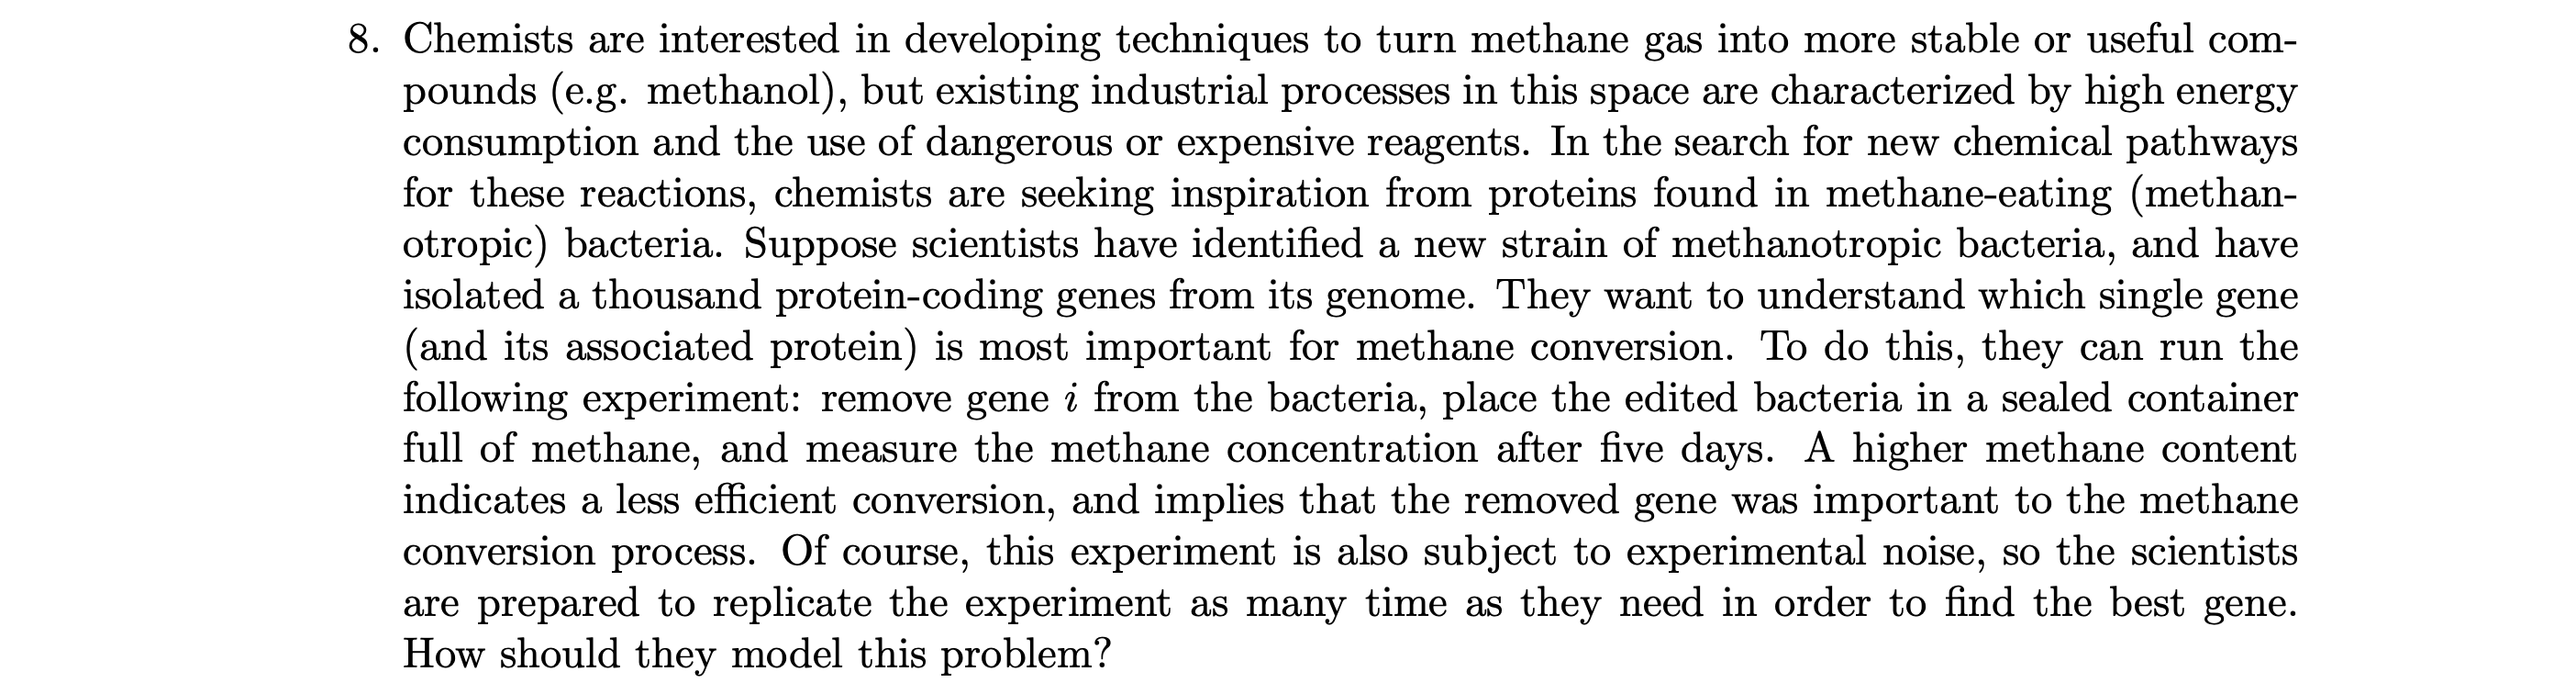

Given that the problem statement mentions removing a single gene to determine which one is most effective, it seems like a simple MAB is the solution. Exploration problem.

Some assumptions:
1. variance in bacteria metabolism and the instrument measurements are adequately captured by the noise.
2. The bacteria is minimally evolving over time, or at least, mutations are not effecting the 1000 genes of interest. Freeze those buggers.

- __Reward__: $\mathbb{E}[r_i] = \mu_i$ - methane content after removing gene $i$. Overall goal is more methane conversion, but in the context of trying to find the gene responsible, we expect that the methane content will go up once the gene is removed, eg. removal of the correct gene leads to high reward.

Especially since there is noise involved and this is an exploration problem, just running 1000 tests, one on each gene, is not sufficient. I suggest MAB elimination since we have a clear stopping point and discover the gene. Unfortunately, this will take many tests if the "best" gene is only marginally more responsible than other genes. This is actually quite a likely scenario, genes are rarely solely responsible for an observable and are instead coupled. Might be better to consider the absence or presence of each gene as a binary feature vector with some sort of maximum removal (say max 10 genes removed. We then have a $d=1000$ length vector with max 10 1's and the rest 0s. Assuming that the genes responsible are not more than 10 this will probably identify the genes much faster since from the MAB perspective $\textrm{min}_i \Delta_i$ is probably quite small. But the problem is set up for MAB.

***
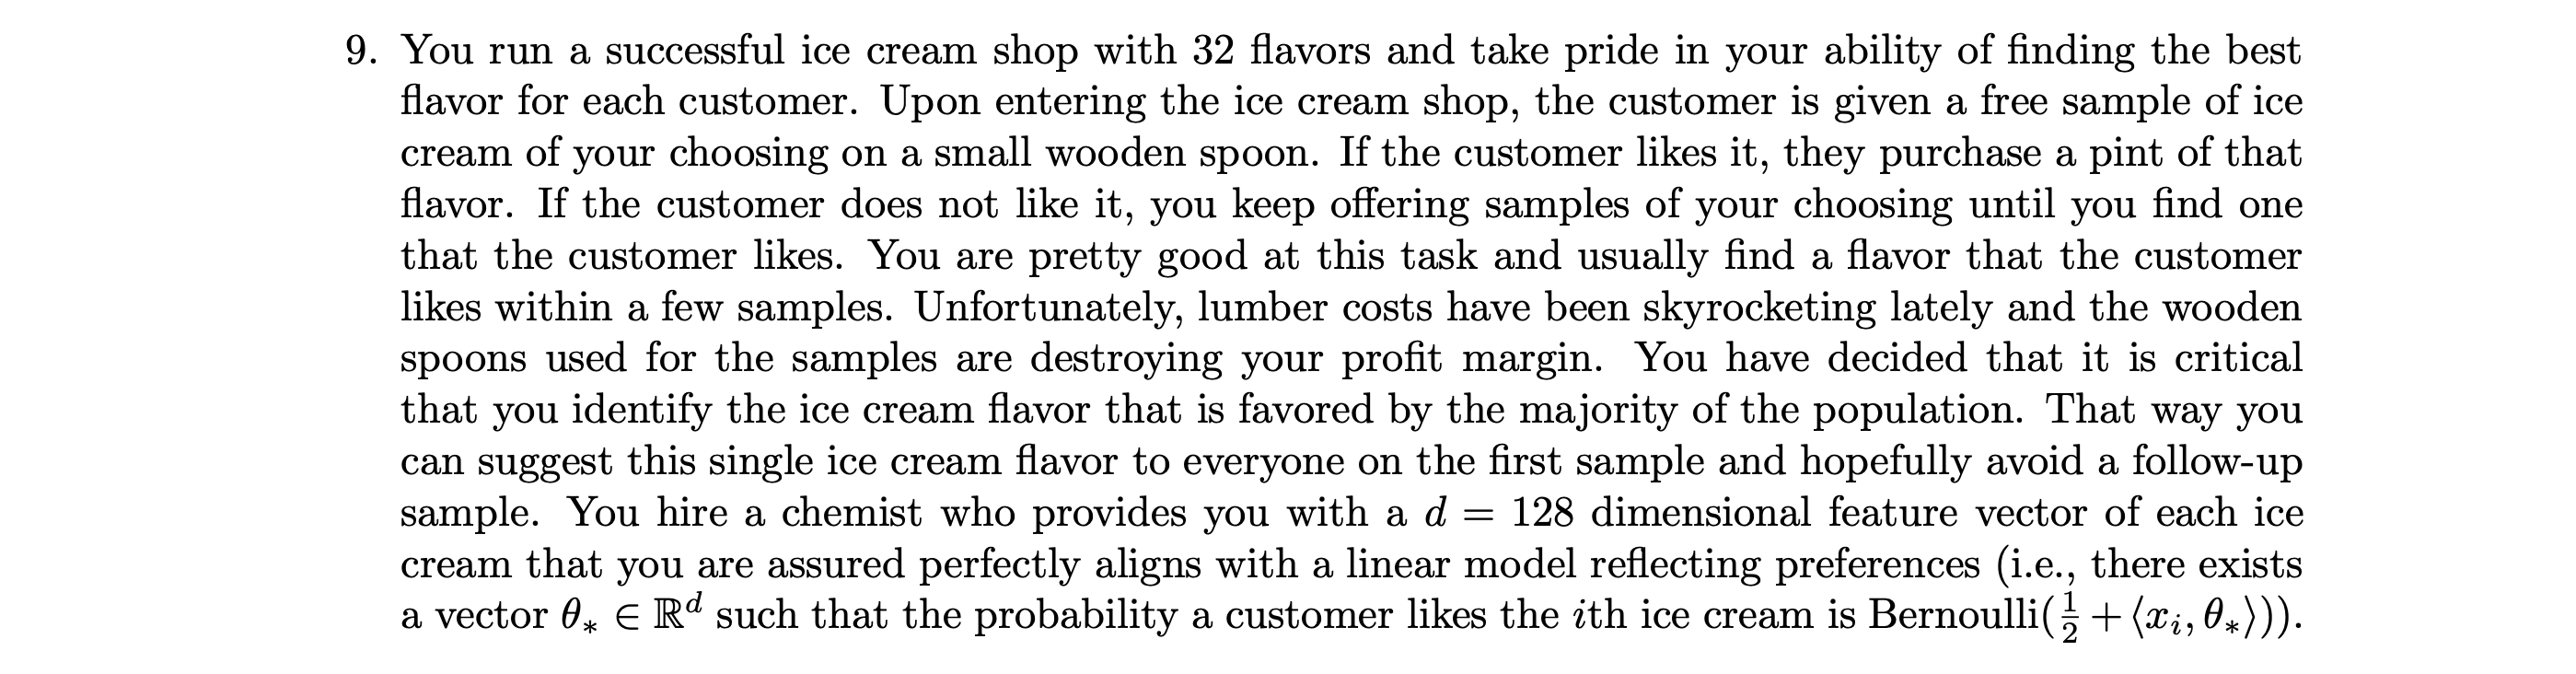

Feature vector given by the chemist. I assume we cannot get some information about the customer to turn this into a contextual bandit problem, and instead have to take population average. Regret minimization.

There are only 32 arms ... and the feature vector is size 128. Hmm. Recalling MAB scaling $\sqrt{nT\ln{T}}$ and linear bandit scaling $\sqrt{dT\ln{nT}}$

In [3]:
import numpy as np
print('Linear bandit regret scaling: ', 128*np.log(32))
print('MAB regret scaling: ', 32)

Linear bandit regret scaling:  443.614195558365
MAB regret scaling:  32


It is a bait! There are few anough arms and the features are large enough that its better to just treat this as a 32 arm MAB. You almost got me.

Some assumptions:
1. We cannot get any information about the customer, we have to settle with population average.
2. The ice cream does not change over time. Same 32 flavors.
3. Customer's palatte is not impacted by previous tastes.

- __Reward__: $\mathbb{E}[r_i] = \mu_i$ - Liklihood of buying a pint of flavor $i$ accross the population. 1 if true, 0 if false.

Run UCB with one change. Hard code so that a flavor is not given to a single customer twice. That is, when the customer walks in, fix the UCB's of each of 32 arms and choose from that in descending order. Only update the bounds after the customer is satisfied. Otherwise it is possible for UCB to suggest the same favlor twice to the same customer. We don't want to use elimination since we don't want to eliminate favors, we want "second best" information etc.


It occurred to me after writing this that you could consider it a MDP. Here the state is which flavors have been given, action is which to give next, and reward is pint buy. Then you could roll out policies with UCB VI to determine which policy (order) reaches the reward faster. But the MDP is only necessary when there is some unknown transition function, and here the next state is deterministic based on an action. So the action in this case can just be considered a MAB with each ice cream flavor having some population mean pint buying. 

***
***
## problem 3: Optimal Design Scenarios

We have proteins $x\in\mathcal{X}:\mathbb{R}^d$, and we sample $n$ samples from $\mathcal{X}$ according to the PMF $\lambda$ in order to produce a linear estimator $\hat{\theta}$ of binding affinity $\mathbb{E}[Y|x] = \theta_*x^T$. How should we determine $\lambda$ depending on the desire?

### 3.1 In minimizing the maximum MSE

We would choose G optimality. This design matrix has the effect of minimizing $\textrm{max}_x\mathbb{E}[(x^T(\hat{\theta} - \theta_*))^2]$ which is exactly minimizing the MSE of accross the datapoints x. 

Keifer Wolfowitz (the best lemma ever) suggests that D optimality is equivalent, so that one works too.

### 3.2 In minimizing the the worst error on some future datapoint

We would use E optimality. This design equation effectively minimizes $\textrm{sup}_u\mathbb{E}[(u^T(\hat{\theta} - \theta_*))^2]$ which is interpereted as minmimizing the worst case error for any future data point. Similiar to G except that instead of considering the dataset we have, we are considering the maximum confidence elipsoid in all directions.

### 3.2 In minimizing the average error

We would use A optimality. This has the effect of minimizing $\mathbb{E}[||\hat{\theta}-\theta_*||^2_2]$, which is exactly the norm of the width of the confidence ellipsoid in all directions.


***
***
## Acknowledgments

Just wanted to say thank you to all three of you, as a non-major this class beat me up but it was really fun!!